In [36]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('cleaned_stock_data.csv', parse_dates=['Date'])
df['target'] = df['Close'].shift(-1)
df.sort_values('Date', inplace=True)
df.dropna(inplace=True)

In [38]:
df['target'] = df['Close'].shift(-1)
df['Volume_log'] = np.log1p(df['Volume'])
df['Return_clipped'] = df['Return'].clip(-0.05, 0.05)

In [39]:
df.head()

,Open,High,Low,Close,Volume,Date,stock_id,target,ema_20,rsi,macd,bb_upper,bb_lower,Return,macd_signal,Volume_log,Return_clipped
0,694.993972,695.705863,686.985079,692.324341,5121009,2020-01-28,INFY.NS,702.735901,681.899348,65.439790,5.594848,711.490452,636.152664,-0.000128,4.572307,15.448862,-0.000128
1,699.977249,705.494498,697.886060,702.735901,6832757,2020-01-29,INFY.NS,694.726990,684.160146,70.718164,6.196757,714.936200,637.409925,0.015039,4.900222,15.737239,0.015039
2,702.735883,702.735883,692.324311,694.726990,3859680,2020-01-30,INFY.NS,690.500061,685.291657,62.775660,6.051716,716.324465,640.115092,-0.011397,5.132232,15.166095,-0.011397
3,694.593473,698.508954,686.629064,690.500061,6092028,2020-01-31,INFY.NS,682.891602,685.842851,59.008801,5.580317,717.404140,641.700591,-0.006084,5.222382,15.622492,-0.006084
4,695.883783,703.848193,680.310937,682.891602,6416745,2020-02-03,INFY.NS,701.089600,685.533800,52.860237,4.625268,717.234144,644.411187,-0.011019,5.102392,15.674422,-0.011019


In [40]:
features = ['Close', 'ema_20', 'rsi', 'macd', 'macd_signal', 
            'bb_upper', 'bb_lower', 'Volume_log', 'Return_clipped']
df['target'] = df['Close'].shift(-1)
target = 'target'

In [41]:
from sklearn.preprocessing import MinMaxScaler

# 1. Scale features
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(df[features])

# 2. Scale target separately
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(df[[target]])


In [42]:
scaled_data = np.hstack([X_scaled, y_scaled]) 

In [43]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1): 
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])  
    return np.array(X), np.array(y)


SEQ_LEN = 90
X, y = create_sequences(scaled_data, SEQ_LEN)

In [44]:
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [45]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1) 
])

d:\projects\stock_price_prediction\stock\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 90, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1061 - val_loss: 0.0030
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0084 - val_loss: 0.0013
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0058 - val_loss: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0050 - val_loss: 0.0016
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0051 - val_loss: 9.2501e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss:

In [48]:
preds = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


In [49]:
preds_inv = target_scaler.inverse_transform(preds)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

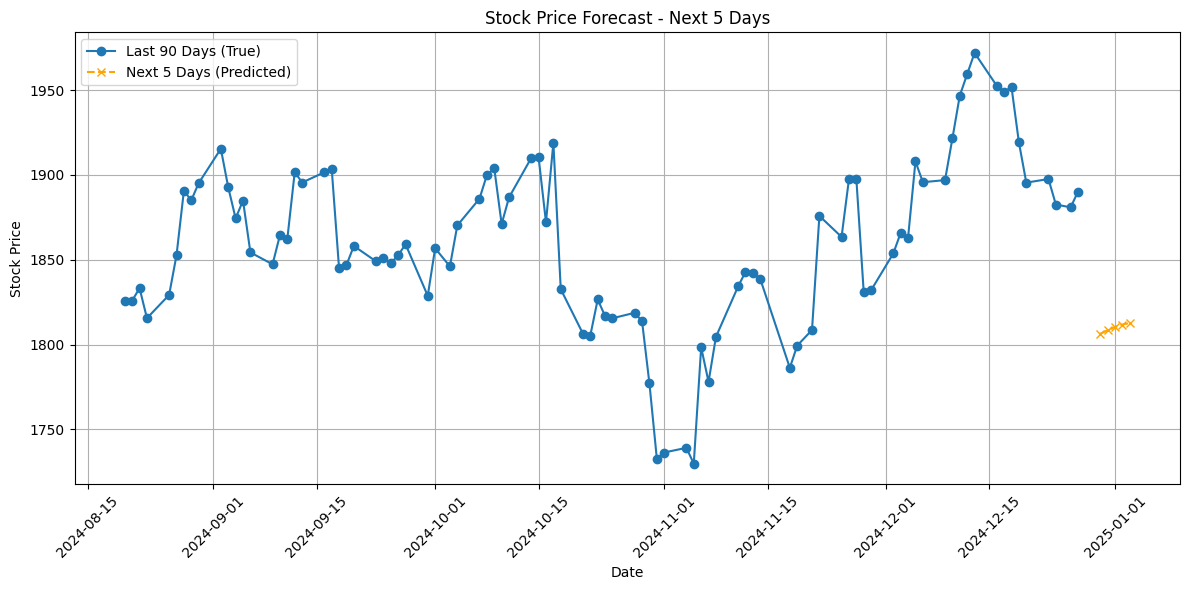

In [50]:
last_seq = scaled_data[-90:, :-1]  

future_preds_scaled = []
current_seq = last_seq.copy()

for _ in range(5):
    input_seq = np.expand_dims(current_seq, axis=0)  
    next_pred_scaled = model.predict(input_seq, verbose=0)[0][0]  
    future_preds_scaled.append(next_pred_scaled)
    
    next_input = np.append(current_seq[-1], next_pred_scaled)  
    current_seq = np.vstack([current_seq, next_input[:-1]])  
    current_seq = current_seq[-90:] 
future_preds = target_scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

last_close_prices = df['Close'].values[-90:]
last_dates = df['Date'].values[-90:]

future_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=5, freq='B')

plt.figure(figsize=(12, 6))
plt.plot(last_dates, last_close_prices, label='Last 90 Days (True)', marker='o')
plt.plot(future_dates, future_preds, label='Next 5 Days (Predicted)', marker='x', linestyle='--', color='orange')
plt.title('Stock Price Forecast - Next 5 Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

y_flat = y_test_inv.flatten()
pred_flat = preds_inv.flatten()

mae = mean_absolute_error(y_flat, pred_flat)
rmse = np.sqrt(mean_squared_error(y_flat, pred_flat))
mape = np.mean(np.abs((y_flat - pred_flat) / y_flat)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  67.57
RMSE: 79.87
MAPE: 3.88%


In [52]:
def build_lstm_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', 1, 5)

    for i in range(num_layers):
        return_seq = i < num_layers - 1  # return_sequences for all but last LSTM layer
        units = hp.Int(f'units_{i+1}', min_value=32, max_value=128, step=32)
        dropout = hp.Float(f'dropout_{i+1}', min_value=0.1, max_value=0.5, step=0.1)

        if i == 0:
            model.add(LSTM(units=units, return_sequences=return_seq, input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(units=units, return_sequences=return_seq))

        model.add(Dropout(dropout))

    model.add(Dense(1))

    # Optimizer
    lr = hp.Choice('learning_rate', [0.1,0.01,0.001])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    return model


In [53]:
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,                
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='lstm_stock_tuning'
)

tuner.search(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Reloading Tuner from tuner_logs\lstm_stock_tuning\tuner0.json


In [54]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Best Hyperparameters: {'units_1': 96, 'dropout_1': 0.2, 'units_2': 48, 'dropout_2': 0.5, 'learning_rate': 0.01}
Epoch 1/50


d:\projects\stock_price_prediction\stock\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1956 - val_loss: 7.3471e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0032 - val_loss: 8.0099e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 8.1673e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023 - val_loss: 4.8507e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0019 - val_loss: 7.4483e-04
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0019 - val_loss: 5.9998e-04
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0021 - val_loss: 9.9759e-04
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0018 - val_loss: 9.1302e-04
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [55]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(best_hp.values)

Best Hyperparameters:
{'units_1': 96, 'dropout_1': 0.2, 'units_2': 48, 'dropout_2': 0.5, 'learning_rate': 0.01, 'num_layers': 1}


In [56]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [57]:
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 9.7121e-04 - val_loss: 5.3904e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9.7409e-04 - val_loss: 4.5194e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.9762e-04 - val_loss: 5.3997e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011 - val_loss: 6.0566e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.0956e-04 - val_loss: 5.0049e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.0452e-04 - val_loss: 5.8429e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0011 - val_loss: 7.2292e-04


In [58]:
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3660e-04
Test Loss: 0.0006986305816099048


In [59]:
def predict_next_days(model, scaled_data, target_scaler, seq_len=90, forecast_days=5):
    
    current_seq = scaled_data[-seq_len:, :-1].copy() 
    future_preds_scaled = []

    for _ in range(forecast_days):
        input_seq = np.expand_dims(current_seq, axis=0)

        pred_scaled = model.predict(input_seq, verbose=0)[0, 0]

        future_preds_scaled.append(pred_scaled)

        next_input = current_seq[-1].copy()
        next_input[0] = pred_scaled 
        
        current_seq = np.vstack([current_seq[1:], next_input])

    future_preds = target_scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

    return future_preds



In [60]:
SEQ_LEN = 90
forecast_days = 5

predicted_prices = predict_next_days(best_model, scaled_data, target_scaler, seq_len=SEQ_LEN)

print(predicted_prices)


[1865.0515 1867.8806 1868.9641 1869.9857 1870.6373]


In [61]:
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='B')

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': predicted_prices
}).set_index('Date')

print(forecast_df)


            Predicted_Close
Date                       
2024-12-30      1865.051514
2024-12-31      1867.880615
2025-01-01      1868.964111
2025-01-02      1869.985718
2025-01-03      1870.637329


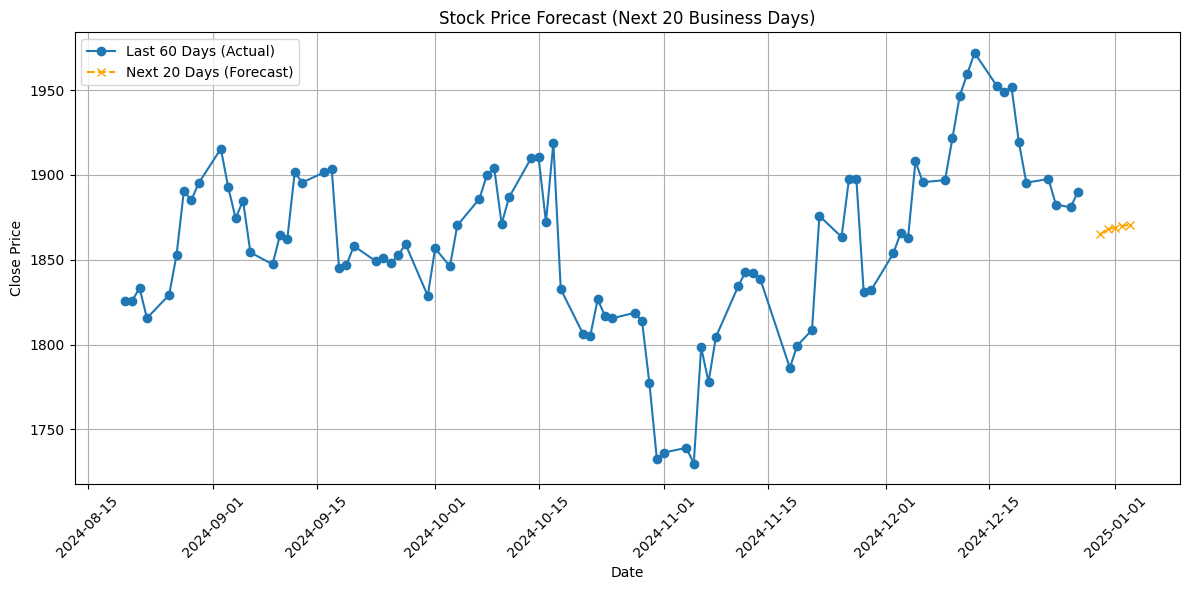

In [62]:
import matplotlib.pyplot as plt

last_close = df['Close'].values[-90:]
last_dates = df['Date'].values[-90:]

plt.figure(figsize=(12, 6))
plt.plot(last_dates, last_close, label='Last 60 Days (Actual)', marker='o')
plt.plot(forecast_df.index, forecast_df['Predicted_Close'], label='Next 20 Days (Forecast)', marker='x', linestyle='--', color='orange')

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Forecast (Next 20 Business Days)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_flat = y_test_inv.flatten()
pred_flat = preds_inv.flatten()

mae = mean_absolute_error(y_flat, pred_flat)
rmse = np.sqrt(mean_squared_error(y_flat, pred_flat))
mape = np.mean(np.abs((y_flat - pred_flat) / y_flat)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  67.57
RMSE: 79.87
MAPE: 3.88%


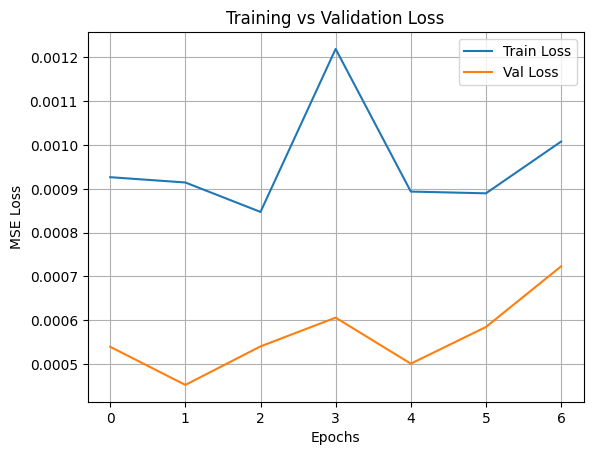

In [64]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
